# Load Trips

In [133]:
import pandas as pd
df = pd.read_csv('gkne-dk5s.csv')

In [134]:
# Show basic info
# print(df.shape)
# print(df.columns)
# print(df.head())

In [135]:
#scale down the data to 20000 rows, throw away the rest
df_small = df.sample(n=20000, random_state=42)
df=None

## Focus on Manhattan Area

In [136]:
from shapely.geometry import Point, Polygon

# Approximate Manhattan Island boundary (lat, lon)
# This polygon is slightly simplified for speed
manhattan_boundary = [
(40.69725142806015, -74.0275049264381),
(40.754590756197786, -74.01531462438582),
(40.87989615299748, -73.92767719381813),
(40.87262749864378, -73.90965274935205),
(40.864644039094046, -73.91351513030905),
(40.847440631613864, -73.92793468596389),
(40.83490854620767, -73.93411449549512),
(40.80802822791165, -73.93298648628877),
(40.79979662922887, -73.92721396298843),
(40.77270851328945, -73.94404916809778),
(40.744655402023966, -73.96764049824235),
(40.710552392905605, -73.97432377654798)
]

# Create shapely polygon
manhattan_poly = Polygon(manhattan_boundary)

def is_in_manhattan(lat, lon):
    """Check if a point is inside the Manhattan polygon."""
    point = Point(lat, lon)
    return manhattan_poly.contains(point)

def both_in_manhattan(origin, destination):
    """
    origin: (lat, lon)
    destination: (lat, lon)
    Returns True if both are inside Manhattan.
    """
    return is_in_manhattan(*origin) and is_in_manhattan(*destination)

# Quick test cases:
# origin = (40.748817, -73.985428)  # Empire State Building
# destination = (40.7128, -74.0060)  # Lower Manhattan

# print(both_in_manhattan(origin, destination))  # True

# origin = (40.748817, -73.985428)  # Empire State Building
# destination = (40.75619279527239, -73.94857464999278)  # Outside Manhattan
# print(both_in_manhattan(origin, destination))  # False


In [137]:
#filter the dataframe to only include rows where both pickup and dropoff are in Manhattan
df_small = df_small[df_small.apply(lambda row: both_in_manhattan((row['pickup_latitude'], row['pickup_longitude']),
                                                                  (row['dropoff_latitude'], row['dropoff_longitude'])), axis=1)]
print(df_small.shape)

(16632, 19)


# Recover Routes and Pickle Data

In [138]:
#load graph
import pickle
with open('g_proj.pkl', 'rb') as f:
    G_proj = pickle.load(f)
with open('g.pkl', 'rb') as f:
    G = pickle.load(f)

In [139]:
import osmnx as ox
def recover_route(graph, pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    orig_node = ox.distance.nearest_nodes(graph, pickup_lon, pickup_lat)
    dest_node = ox.distance.nearest_nodes(graph, dropoff_lon, dropoff_lat)

    #print(f"Pickup Node: {orig_node}, Dropoff Node: {dest_node}")
    #print(f"Pickup Coordinates: ({pickup_lat}, {pickup_lon}), Dropoff Coordinates: ({dropoff_lat}, {dropoff_lon})")
    # Compute the shortest path by length (distance)
    # route = ox.shortest_path(graph, orig_node, dest_node, weight='length')
    # Compute the shortest path by travel time
    route = ox.shortest_path(graph, orig_node, dest_node, weight='travel_time')
    #route = ox.shortest_path(graph, orig_node, dest_node)
    return route

In [140]:
# Check the first route
#recover_route(G_proj, df['pickup_latitude'].iloc[0], df['pickup_longitude'].iloc[0], df['dropoff_latitude'].iloc[0], df['dropoff_longitude'].iloc[0])

In [141]:
filename = 'routed_df_20000_MANHATTAN_shortest.pkl'

pickup_lat = df_small['pickup_latitude']
pickup_lon = df_small['pickup_longitude']
dropoff_lat = df_small['dropoff_latitude']
dropoff_lon = df_small['dropoff_longitude']
df_small['route'] = recover_route(G_proj, pickup_lat, pickup_lon, dropoff_lat, dropoff_lon)
#~70 seconds for 10,000 routes

#eliminate those with empty routes: disconnected? too close? ~0.4%
df_small = df_small[df_small['route'].apply(lambda x: x is not None and len(x) > 0)]
print(f"Remaining rows after filtering: {df_small.shape[0]}")

# Save the route to a pickle file
with open(filename, 'wb') as f:
    pickle.dump(df_small, f)


Remaining rows after filtering: 16613


# Visualize Route

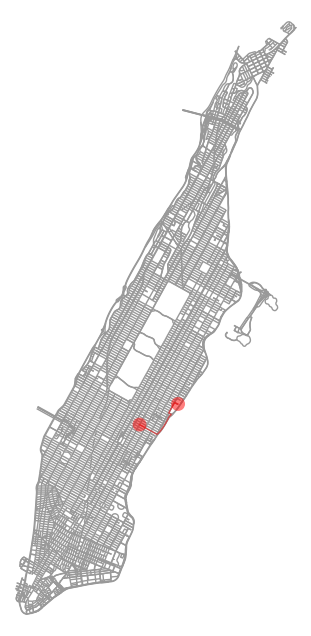

In [142]:
import osmnx as ox
import matplotlib.pyplot as plt

# Example: plot a single route
def plot_route(graph, route):
    fig, ax = ox.plot_graph_route(graph, route, route_linewidth=1, node_size=0, bgcolor='white')
    plt.show()

plot_route(G_proj, df_small['route'].iloc[6])

In [143]:
#print(df_small['route'].iloc[1])
#congestion=df_small['route'].iloc[1]
# add the first 10 routes to congestion and make edges unique
congestion = set()
for i in df_small['route'].iloc[:10]:
    for j in i:
        congestion.add(j)


# Augment with Scalar Variables

In [144]:
def get_edge_length_sum(graph, route):
    edge_length = 0
    if not route:
        print("Warning: The route is empty.")
        return edge_length
    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]
        if v not in graph[u]:
            print(f"Warning: Edge {u} to {v} not found in the graph.")
            continue
        length = graph[u][v][0]['length']
        edge_length += length
    return edge_length

In [145]:
import numpy as np

df_small['pickup_datetime'] = pd.to_datetime(df_small['pickup_datetime'])
df_small['dropoff_datetime'] = pd.to_datetime(df_small['dropoff_datetime'])

df_small['duration_seconds'] = (df_small['dropoff_datetime'] - df_small['pickup_datetime']).dt.total_seconds()
#df_small['pickup_hour'] = df_small['pickup_datetime'].dt.hour
# Add sine and cosine transformations for pickup min of the day
df_small['pickup_min_sin'] = np.sin(2 * np.pi * (df_small['pickup_datetime'].dt.hour + df_small['pickup_datetime'].dt.minute/60) / 24)
df_small['pickup_min_cos'] = np.cos(2 * np.pi * (df_small['pickup_datetime'].dt.hour + df_small['pickup_datetime'].dt.minute/60) / 24)

df_small['pickup_weekday'] = df_small['pickup_datetime'].dt.weekday

# Then for each trip get the route length
df_small['route_length'] = df_small['route'].apply(lambda route: get_edge_length_sum(G_proj, route))

In [146]:
df_small.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'mta_tax', 'tip_amount', 'tolls_amount',
       'total_amount', 'imp_surcharge', 'extra', 'rate_code', 'route',
       'duration_seconds', 'pickup_min_sin', 'pickup_min_cos',
       'pickup_weekday', 'route_length'],
      dtype='object')

# Add Route-derived Featyres

In [147]:
def get_route_features(graph, route):
    if not route or len(route) < 2:
        print(route)
        return None
    return pd.Series({
        'num_edges': len(route) - 1,
        'motor_len': sum(graph[route[i]][route[i + 1]][0]['length'] for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'motorway' or graph[route[i]][route[i + 1]][0].get('highway') == 'motorway_link'),
        'trunk_len': sum(graph[route[i]][route[i + 1]][0]['length'] for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'trunk' or graph[route[i]][route[i + 1]][0].get('highway') == 'trunk_link'),
        'primary_len': sum(graph[route[i]][route[i + 1]][0]['length'] for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'primary'or graph[route[i]][route[i + 1]][0].get('highway') == 'primary_link'),
        'secondary_len': sum(graph[route[i]][route[i + 1]][0]['length'] for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'secondary' or graph[route[i]][route[i + 1]][0].get('highway') == 'secondary_link'),
        'tertiary_len': sum(graph[route[i]][route[i + 1]][0]['length'] for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'tertiary'),
        'residential_len': sum(graph[route[i]][route[i + 1]][0]['length'] for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'residential'),
        'unclassified_len': sum(graph[route[i]][route[i + 1]][0]['length'] for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'unclassified'),
        'motor_segments': sum(1 for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'motorway' or graph[route[i]][route[i + 1]][0].get('highway') == 'motorway_link'),
        'trunk_segments': sum(1 for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'trunk' or graph[route[i]][route[i + 1]][0].get('highway') == 'trunk_link'),
        'primary_segments': sum(1 for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'primary' or graph[route[i]][route[i + 1]][0].get('highway') == 'primary_link'),
        'secondary_segments': sum(1 for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'secondary' or graph[route[i]][route[i + 1]][0].get('highway') == 'secondary_link'),
        'tertiary_segments': sum(1 for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'tertiary'),
        'residential_segments': sum(1 for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'residential'),
        'unclassified_segments': sum(1 for i in range(len(route) - 1) if graph[route[i]][route[i + 1]][0].get('highway') == 'unclassified')
    })
    return features

In [148]:
#check the first route features
# get_route_features(G_proj, df_small['route'].iloc[0])

# Add congestion

In [149]:
import random
for r in df_small.itertuples():
    #print(r)
    if r.pickup_weekday<5 or r.pickup_min_cos>0: #just happens on weekend, mid-day
        continue
    for i in r.route:
        if i in congestion:
            df_small.at[r.Index,'duration_seconds']+=10+random.randint(5,15) #add ~20sec of congestion for each seg travelled

# Reshape / Split X&Y

In [150]:
from sklearn.model_selection import train_test_split
#make sure all ['route'] are not None
df_small = df_small[df_small['route'].apply(lambda x: x is not None and len(x) >= 2)]
route_features = df_small['route'].apply(lambda route: get_route_features(G_proj, route))
# Combine route features with the main DataFrame
df_combined = pd.concat([df_small.reset_index(drop=True), route_features.reset_index(drop=True)], axis=1)
# Define features including route features
features_with_route = ['route_length', 'num_edges', 'motor_len', 'trunk_len', 'primary_len', 'secondary_len', 'tertiary_len', 'residential_len', 'unclassified_len',
                       'motor_segments', 'trunk_segments', 'primary_segments', 'secondary_segments', 'tertiary_segments', 'residential_segments','unclassified_segments',
                       'pickup_latitude', 'pickup_longitude', 'pickup_min_sin', 'pickup_min_cos', 'pickup_weekday', 'passenger_count']
X_combined = df_combined[features_with_route]
y_combined = df_combined['duration_seconds']
print(X_combined.shape, y_combined.shape)

(16470, 22) (16470,)


In [151]:
pickle.dump((X_combined, y_combined), open('Xy_combined_congestion.pkl', 'wb'))
pickle.dump(df_small, open('df_small_congestion.pkl', 'wb'))

# Transform Edge/Route into either Lat/Lon or ID

In [152]:
#normalize lat and lon
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit the scaler on the pickup and dropoff coordinates
scaler.fit(df_small[['pickup_latitude', 'pickup_longitude']])

StandardScaler()

In [153]:
# hash uv to get unique edge IDs
import hashlib
def hash_edge(u, v):
    edge_str = f"{u}-{v}"
    return hashlib.md5(edge_str.encode()).hexdigest()
def get_edge_ids(route, G):
    edge_ids = []
    for u, v in zip(route[:-1], route[1:]):
        if G.has_edge(u, v):
            edge_data = G.get_edge_data(u, v)
            # Get unique edge ID or use (u, v)
            edge_ids.append(hash_edge(u,v))
    return edge_ids

In [154]:
import numpy as np
# encode the routes with the lat and lon of each node it went thru 
def encode_routes_with_lat_lon(routes, G):
    encoded_routes = []
    for route in routes:
        if not route or len(route) < 2:
            encoded_routes.append(None)
            continue
        edge_ids = get_edge_ids(route, G)
        if not edge_ids:
            encoded_routes.append(None)
            continue
        # Get the lat/lon for each node in the route
        lat_lon_pairs = [[G.nodes[node]['y'], G.nodes[node]['x']] for node in route]

        #Add some noise to the lat/lon pairs ~11 meters for lat and lon (converted with NYC at ~40.7 degrees latitude)
        lat_lon_pairs = [[lat + np.random.uniform(-0.0001, 0.0001), lon + np.random.uniform(-0.00013, 0.00013)] for lat, lon in lat_lon_pairs]
        # Scale the lat/lon pairs

        # Combine edge IDs with lat/lon pairs
        # encoded_route = [(edge_id, lat, lon) for edge_id, (lat, lon) in zip(edge_ids, lat_lon_pairs)]
        encoded_routes.append(scaler.transform(lat_lon_pairs))
    return encoded_routes

In [155]:
encoded_routes = encode_routes_with_lat_lon(df_small['route'].dropna().tolist(), G_proj)

c:\Users\Milli\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Milli\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Milli\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Milli\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Milli\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: U

# Pad Routes

In [156]:
# padding the encoded routes to have the same length
import numpy as np
import torch

def pad_encoded_routes(encoded_routes, max_length):
    padded_routes = []
    for route in encoded_routes:
        if route is None:
            padded_routes.append(np.full((max_length, 2), 0))  # Fill with 0 if route is None
        else:
            padded_route = np.array(route)
            if len(padded_route) < max_length:
                # Pad with NaN if the route is shorter than max_length
                padding = np.full((max_length - len(padded_route), 2), 0)
                padded_route = np.vstack((padded_route, padding))
            elif len(padded_route) > max_length:
                # Truncate if the route is longer than max_length
                padded_route = padded_route[:max_length]
            padded_routes.append(padded_route)
    return np.array(padded_routes)
max_route_length = max(len(route) for route in df_small['route'].dropna().tolist())
padded_routes = pad_encoded_routes(encoded_routes, max_route_length)

In [157]:
pickle.dump(padded_routes, open('padded_routes.pkl', 'wb'))
pickle.dump(encoded_routes, open('encoded_routes.pkl', 'wb'))

# try one-hot encoding as route

In [168]:
# use sparse tensors for one-hot encoding of the routes (1 as have travelled through the edge in the trip, 0 as not, assuming one won't travel through the same edge twice)
#shape: (num_routes, max_length, num_edges)
import torch
def one_hot_encode_routes(routes, edge_ids, max_length):
    """
    routes: list of lists, where each inner list is a route represented by edge IDs
    edge_ids: list of unique edge IDs in the graph
    max_length: maximum length of the routes to pad to
    Returns a sparse tensor of shape (num_routes, max_length, num_edges)
    """
    returnvec = torch.zeros((len(routes), len(edge_ids)), dtype=torch.float32)
    for i, route in enumerate(routes):
        for j, edge_id in enumerate(edge_ids):
            if edge_id in route:
                returnvec[i, edge_ids.index(edge_id)] = 1.0
    return returnvec

edge_ids = list(set(hash_edge(u, v) for route in df_small['route'].dropna().tolist() for u, v in zip(route[:-1], route[1:])))
one_hot_routes = one_hot_encode_routes(df_small['route'].dropna().tolist(), edge_ids, max_route_length)

In [169]:
print(f"One-hot encoded routes shape: {one_hot_routes.shape}, Number of unique edges: {len(edge_ids)}")
#shape: (num_routes, max_length, num_edges)

One-hot encoded routes shape: torch.Size([16470, 6941]), Number of unique edges: 6941


In [170]:
#concat the X_combined to the one_hot_routes
X = np.concatenate((X_combined.values, one_hot_routes.reshape(one_hot_routes.shape[0], -1)), axis=1)

In [164]:
# train a linear regression model to predict the eta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y_combined, test_size=0.2, random_state=42)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
y_pred = lr_model.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Linear Regression MSE: {mse:.2f}, R^2: {r2:.2f}")

Linear Regression MSE: 214.69, R^2: -0.90


In [174]:
# train a MLP model to predict the eta
import torch
import torch.nn as nn
import torch.optim as optim
class MLPModel(nn.Module):
    def __init__(self, input_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Prepare data for PyTorch
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
# Define model, loss function, and optimizer
mlp_model = MLPModel(X_tensor.shape[1])
loss_fn_mlp = nn.L1Loss()
optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001)


In [175]:
#train the MLP model
num_epochs = 100

for epoch in range(num_epochs):
    mlp_model.train()
    optimizer_mlp.zero_grad()
    outputs = mlp_model(X_tensor)
    loss = loss_fn_mlp(outputs, y_tensor)
    loss.backward()
    optimizer_mlp.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
# Evaluate the MLP model
with torch.no_grad():
    mlp_model.eval()
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
    y_pred_mlp = mlp_model(X_test_tensor)
    mse_mlp = mean_absolute_error(y_test_tensor.numpy(), y_pred_mlp.numpy())
    r2_mlp = r2_score(y_test_tensor.numpy(), y_pred_mlp.numpy())
    print(f"MLP Model MSE: {mse_mlp:.2f}, R^2: {r2_mlp:.2f}")

# Save the MLP model
torch.save(mlp_model.state_dict(), 'mlp_model.pth')
print("MLP model saved as 'mlp_model.pth'")

Epoch [10/100], Loss: 513.8543
Epoch [20/100], Loss: 245.3581
Epoch [30/100], Loss: 250.0051
Epoch [40/100], Loss: 227.5587
Epoch [50/100], Loss: 217.7749
Epoch [60/100], Loss: 216.6300
Epoch [70/100], Loss: 216.1997
Epoch [80/100], Loss: 215.6688
Epoch [90/100], Loss: 215.1855
Epoch [100/100], Loss: 214.7303
MLP Model MSE: 219.95, R^2: 0.42
MLP model saved as 'mlp_model.pth'
